In [10]:
import torch
import torch
import torch.nn as nn
import argparse
import torch.optim as optim
import numpy as np

import time
import matplotlib.pyplot as plt
import random

import torch.nn as nn
import argparse
import torch.optim as optim
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from torchdiffeq import odeint_adjoint as odeint
from mpl_toolkits.mplot3d import Axes3D
import random



class Args:
    def __init__(self):
        pass 
    def assign(self,args):
        for key, val in args.items():
            if key != 'self':
                setattr(self, key, val)
scaler = MinMaxScaler()

In [11]:
from platform import python_version

print(python_version())

3.8.12


In [12]:
import transfer_ode as tode
ADJOINT = False
if ADJOINT:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [13]:
import types
def assign_args(args_):
    for arg, val in args_.items():
        fs = []
        for f in globals().values():
            if type(f) == types.FunctionType:
                #print(f)
                try:
                    #print(f.args)
                    f.args = args
                except:
                    fs.append(f)
                    
                    #print(f'f, {id(f)}')
        for f in fs:
            #print(f'f, {id(f)}')
            f.__globals__[arg] = val
                    #f.__globals__["NDIMZ"] = args.hidden_size
def assign_vars(func, key, val):
    func.__globals__[key] = val

In [14]:
# if args.viz:
#     import matplotlib.pyplot as plt

#     fig = plt.figure(figsize=(12, 4), facecolor='white')
#     ax_traj = fig.add_subplot(131, frameon=False)
#     ax_phase = fig.add_subplot(132, frameon=False)
#     ax_vecfield = fig.add_subplot(133, frameon=False)
#     plt.show(block=False)
# if __name__ == '__main__':
scaler = MinMaxScaler()
def optimize(a0 = lambda t: t**2,#-(5./t + t)#-3*t**2
             a1 = lambda t:1 + 0.*t,
             f = lambda t: torch.sin(t),#t**6#3*t**2#torch.sin(t)
             ics = torch.tensor(np.arange(-2.9, 2.9, 0.1), dtype = torch.float32),#torch.linspace(-7.,7.,200),
             method : str = "dopri5", 
             tmax : float = 5,
             #dt   : int   = 0.01,
             method_rc: str = "euler",
             wout : str = "analytic",
             paramg : str = "lin",
             niters : int = 100,
             hidden_size : int = 200,
             viz = False,#'store_false',
             gpu : int = 0,
             adjoint = 'store_false',
             random_sampling = True,
             n_timepoints = 50,
             regularization = 0,
             l1_reg_strength = 0,
             #visualize_ = False,
             niters_test: int =15000,
             num_bundles: int= 20,
             num_bundles_test : int =20,
             test_freq :int =10,
             evaluate_only : bool = False,
             bias_at_inference : bool = False,
             ffnn_bias: bool = False,
             force_bias : int  = 0
            ):
    args = Args()
    
    args.assign(locals())
    tode.args = args
    
    if args.wout == 'analytic':
        wout_gen = tode.Transformer_Analytic(regularization, bias_at_inference)
        #wout_gen = tode.Transformer_Analytic(a0, a1, f, regularization)
        
        
    
    dt=tmax/n_timepoints
    args.dt = dt
    
    if not random_sampling:
        t = torch.arange(0.,args.tmax,args.dt)
    else:
        t = torch.rand(n_timepoints) *tmax
        t = t.sort().values
    
    t = t.reshape(-1,1)
    
    #assign_vars(tode.compute_s_sdot, "t", t)
    assign_args({"t": t})
    
    
    globals()["args"] = args
    
    ii = 0
    NDIMZ = args.hidden_size
    # define coefficients as lambda functions, used for gt and wout_analytic
    # training differential equation

    #need to sample tuple of (a1,f,IC)
    # each column of Wouts defines a solution thus, each tuple defines a solution too


    f_train = [lambda t: torch.cos(t) + force_bias,
               lambda t: torch.cos(t) - force_bias,
               lambda t: torch.sin(t) - force_bias, 
               lambda t: torch.sin(t) + force_bias, 
               lambda t: torch.sin(t)* torch.cos(t) - force_bias,
               lambda t: torch.sin(t)* torch.cos(t) + force_bias]
    a0_train = [lambda t:t**2]
    r1 = -10.
    r2 = 10.
    true_y0 = (r2 - r1) * torch.rand(100) + r1
    t = torch.arange(0., args.tmax, args.dt).reshape(-1, 1)
    t.requires_grad = True

    # sample each parameter to build the tuples
    f_samples = random.choices(f_train, k=args.num_bundles)
    a0_samples = random.choices(a0_train, k=args.num_bundles)
    y0_samples = torch.tensor(random.choices(true_y0, k=args.num_bundles)).reshape(1,-1)

    diffeq_init = tode.diffeq(a0_samples,f_samples)
    gt_generator = tode.base_diffeq(diffeq_init)
    true_y = gt_generator.get_solution(y0_samples,t.ravel()).reshape(-1,args.num_bundles)

    # use this quick test to find gt solutions and check training ICs
    # have a solution (don't blow up for dopri5 integrator)
    # true_y = gt_generator.get_solution(true_y0.reshape(-1, 1), t.ravel())

    # instantiate wout with coefficients
    func = tode.ODEFunc(hidden_dim=NDIMZ, output_dim=args.num_bundles, calc_bias = ffnn_bias)

    optimizer = optim.Adam(func.parameters(), lr=1e-3, weight_decay=1e-6)
    
    

    loss_collector = []
    
    assign_vars(tode.visualize,"args", args)

    if not args.evaluate_only:

        for itr in range(1, args.niters + 1):
            func.train()

            # add t0 to training times, including randomly generated ts
            t0 = torch.tensor([[0.]])
            t0.requires_grad = True
            tv = args.tmax * torch.rand(int(args.tmax / args.dt)).reshape(-1, 1)
            tv.requires_grad = True
            tv = torch.cat([t0, tv], 0)
            optimizer.zero_grad()

            # compute hwout,hdotwout
            pred_y = func(tv)
            pred_ydot = tode.diff(pred_y, tv)
            
            

            # enforce diffeq
            loss_diffeq = pred_ydot - tode.get_udot(tv,pred_y,a0_samples,f_samples)
            # loss_diffeq = (a1(tv.detach()).reshape(-1, 1)) * pred_ydot + (a0(tv.detach()).reshape(-1, 1)) * pred_y - f(
            #     tv.detach()).reshape(-1, 1)

            # enforce initial conditions
            loss_ics = pred_y[0, :].ravel() - y0_samples.ravel()

            loss = torch.mean(torch.square(loss_diffeq)) + torch.mean(torch.square(loss_ics))
            loss.backward()
            optimizer.step()
            loss_collector.append(torch.square(loss_diffeq).mean().item())
            if itr % args.test_freq == 0:
                func.eval()
                pred_y = func(t).detach()
                pred_y = pred_y.reshape(-1, args.num_bundles)
                tode.visualize(true_y.detach(), pred_y.detach(), loss_collector)
                ii += 1

        torch.save(func.state_dict(), 'func_ffnn_bundles')

    # with torch.no_grad():

    f_test = [lambda t: torch.sin(t)]
    a0_test = [lambda t: t**3]
    r1 = -15.
    r2 = 15.
    true_y0 = (r2 - r1) * torch.rand(100) + r1
    t = torch.arange(0., args.tmax, args.dt).reshape(-1, 1)
    t.requires_grad = True

    # sample each parameter to build the tuples
    f_samples = random.choices(f_test, k=args.num_bundles_test)
    a0_samples = random.choices(a0_test, k=args.num_bundles_test)
    y0_samples = torch.tensor(random.choices(true_y0, k=args.num_bundles_test)).reshape(1, -1)

    # print(y0_samples.shape)
    diffeq_init = tode.diffeq(a0_samples, f_samples)
    gt_generator = tode.base_diffeq(diffeq_init)


    func.load_state_dict(torch.load('func_ffnn_bundles'))
    func.eval()

    h = func.h(t)
    hd = tode.diff(h, t)
    h = h.detach()
    hd = hd.detach()

    gz_np = h.detach().numpy()
    T = np.linspace(0, 1, len(gz_np)) ** 2
    new_hiddens = scaler.fit_transform(gz_np)
    pca = PCA(n_components=3)
    pca_comps = pca.fit_transform(new_hiddens)

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    if pca_comps.shape[1] >= 2:
        s = 10  # Segment length
        for i in range(0, len(gz_np) - s, s):
            ax.plot3D(pca_comps[i:i + s + 1, 0], pca_comps[i:i + s + 1, 1], pca_comps[i:i + s + 1, 2],
                      color=(0.1, 0.8, T[i]))
            plt.xlabel('comp1')
            plt.ylabel('comp2')


    s1 = time.time()
    
    wout, bias = wout_gen.get_wout(h, hd, y0_samples, t.detach(), a0_samples[0], f_samples)
    #wout = tode.get_wout(h, hd, y0_samples, t.detach(),a0_samples[0],f_samples)
    pred_y = h @ wout + bias
    s2 = time.time()
    print(f'all_ics:{s2 - s1}')

    s1 = time.time()
    true_ys = (gt_generator.get_solution(y0_samples, t.ravel())).reshape(-1, args.num_bundles_test)
    s2 = time.time()
    print(f'gt_ics:{s2 - s1}')

    print(true_ys.shape,pred_y.shape)

    # s1 = time.time()
    # true_y = estim_generator.get_solution(ics.reshape(-1, 1), t.ravel())
    # estim_ys = true_y.reshape(len(pred_y), ics.shape[1])
    # s2 = time.time()
    # print(f'estim_ics:{s2 - s1}')

    # print(f'prediction_accuracy:{((pred_y - true_ys) ** 2).mean()} pm {((pred_y - true_ys) ** 2).std()}')
    # print(f'estim_accuracy:{((estim_ys - true_ys) ** 2).mean()} pm {((estim_ys - true_ys) ** 2).std()}')

    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    # print(true_ys[0,:])
    for i in range(0, args.num_bundles_test, 50):
        gt = true_ys.cpu().numpy()[:, i]
        preds = pred_y.cpu().numpy()[:, i]
        ax[0].plot(t.detach().cpu().numpy(), gt, c='blue', linestyle='dashed')
        ax[0].plot(t.detach().cpu().numpy(),  preds , c='orange')
        # plt.draw()

    ax[1].plot(t.detach().cpu().numpy(), ((true_ys - pred_y) ** 2).mean(1).cpu().numpy(), c='green')
    ax[1].set_xlabel('Time (s)')
    plt.legend()
    plt.show()
    
    prediction_residuals = ((pred_y - true_ys) ** 2)
    #estimation_residuals = ((estim_ys - true_ys) ** 2)
    score = prediction_residuals.mean()
    return score, pred_y, true_y#, estim_ys

In [15]:
shared_args = {"a0" : lambda t: t**2,#-(5./t + t)#-3*t**2
               "a1" : lambda t:1 + 0.*t,
               "f" : lambda t: torch.sin(t),
               "num_bundles" : 20}
               #"n_timepoints" : 30}
    
no_bias = {"bias_at_inference" : False, 
           "ffnn_bias" : True, **shared_args}

bias = {"bias_at_inference" : True, 
           "ffnn_bias" : True, **shared_args}


In [16]:
n = 2
force_bias = np.array(range(n + 1) )-n/2
force_bias

array([-1.,  0.,  1.])

In [ ]:
%%time
optimize(**no_bias, force_bias = f, n_timepoints = 50)

No handles with labels found to put in legend.


all_ics:0.006047964096069336
gt_ics:0.1423170566558838
torch.Size([50, 20]) torch.Size([50, 20])


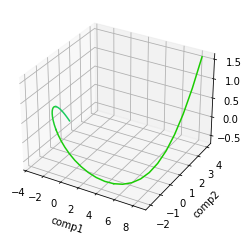

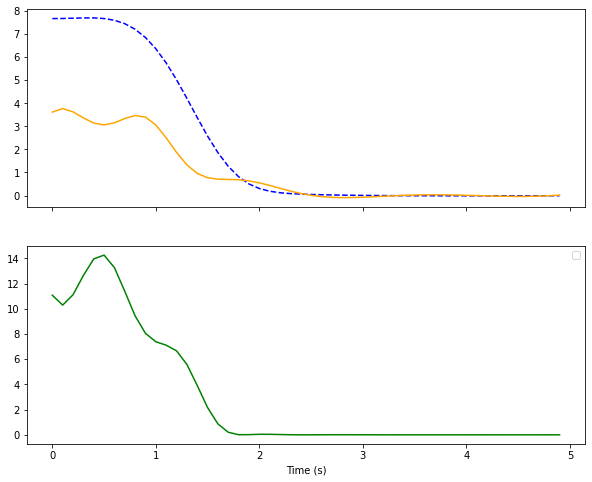

No handles with labels found to put in legend.


all_ics:0.1373739242553711
gt_ics:0.14359712600708008
torch.Size([50, 20]) torch.Size([50, 20])


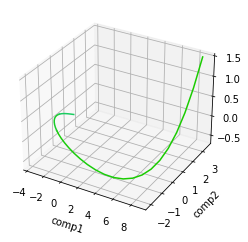

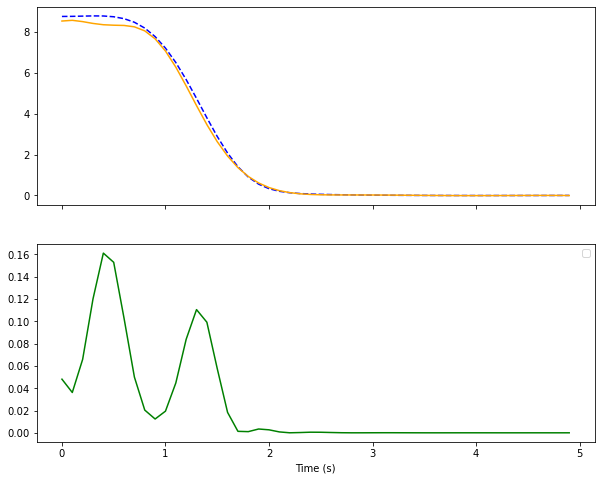

No handles with labels found to put in legend.


all_ics:0.0056912899017333984
gt_ics:0.14143729209899902
torch.Size([50, 20]) torch.Size([50, 20])


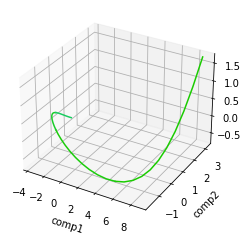

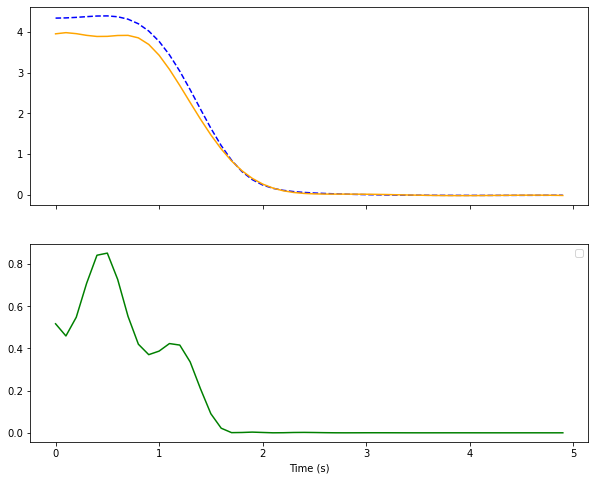

No handles with labels found to put in legend.


all_ics:0.0075991153717041016
gt_ics:0.13922595977783203
torch.Size([50, 20]) torch.Size([50, 20])


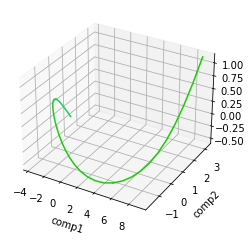

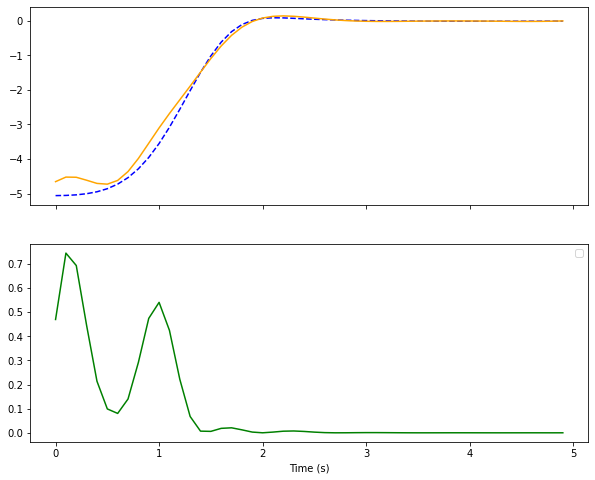

No handles with labels found to put in legend.


all_ics:0.013823986053466797
gt_ics:0.14017105102539062
torch.Size([50, 20]) torch.Size([50, 20])


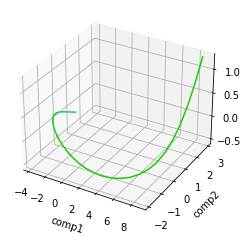

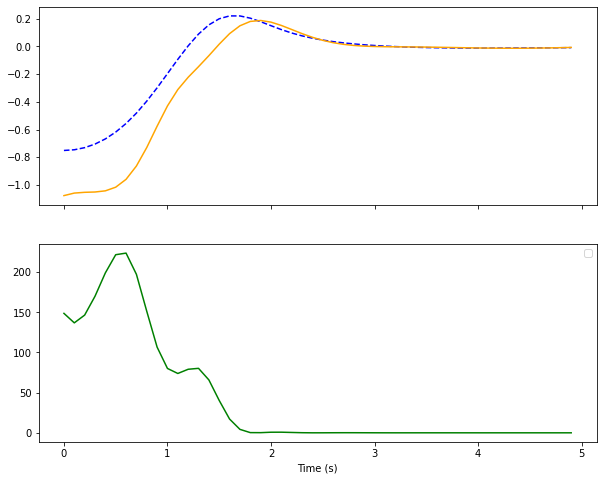

No handles with labels found to put in legend.


all_ics:0.014742851257324219
gt_ics:0.14023900032043457
torch.Size([50, 20]) torch.Size([50, 20])


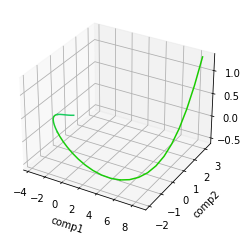

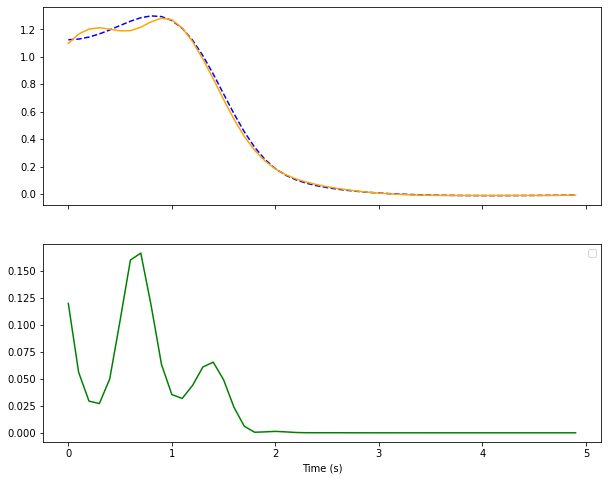

CPU times: user 2min 26s, sys: 55.7 s, total: 3min 21s
Wall time: 30.8 s


In [17]:
%%time
b_results = []
nb_results = []

for f in force_bias:
    nb_results.append(optimize(**no_bias,
                               force_bias = f,
                               n_timepoints = 50))
    b_results.append(optimize(**bias, 
                                 force_bias = f,
                                 n_timepoints = 50))

In [9]:
b_scores = [{"score":float(result[0]), "n" :n_timepoints[i], "bias" : True} for i, result in enumerate(b_results)]
nb_scores = [{"score":float(result[0]), "n" :n_timepoints[i], "bias" : False} for i, result in enumerate(nb_results)]

NameError: name 'n_timepoints' is not defined

In [ ]:
import pandas as pd 
import seaborn as sns

In [ ]:
df = pd.DataFrame(b_scores + nb_scores)
df

In [ ]:
sns.barplot(data = df,x = "n", y = "score", hue = "bias")
plt.yscale("log")
plt.xlabel("n_timpoints")
plt.ylabel("score (MSE)")

In [ ]:
# %%time
# losses_l1 = []
# for l1 in [0.0001, 0.001, 0.01, 0.1, 0]:
#     score, pred, gt = optimize(a0 = lambda t: t**2,#-(5./t + t)#-3*t**2
#                                 a1 = lambda t:1 + 0.*t,
#                                 f = lambda t: torch.sin(t),
#                                 n_timepoints = 100,
#                                 regularization = 1)
#                                 #l1_reg_strength = l1)
#     data_point = {"score" : float(score), "l1_reg" : l1}
#     losses_l1.append(data_point) #[str(l1)] = (score)